In [1]:
import warnings
warnings.filterwarnings("ignore")

Titanic competition is a very good way to introduce feature engineering and classification models. I'm gonna explore the data and make something with them and also imput missing values. Feature engineering is an important part of machine learning process so I want to spend more time for this part. I'm gonna try I few models and tell you which work the best with train dataset from this competition. Please consider upvoting if this is useful to you :)

**Import the Libraries**

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import math 
import xgboost as xgb
np.random.seed(2019)
from scipy.stats import skew
from scipy import stats

import statsmodels
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
print("done")

done


**Import Data**

I'm adding here 'train' variable in order to check in the easiest way later which observations are from train and test dataset because I'm gonna join train and test datasets.

In [4]:
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data

train, test, data = read_and_concat_dataset('train.csv', 'test.csv')
data = data.set_index('PassengerId')

##**Explore the Data**

In [5]:
data.head(5)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,train
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,1
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,1
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,1
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1


In [6]:
data.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


**PassengerId** - the unique id of the row, it doesn't have any effect on Survived value.

**Survived** - binary:
* 1 -> Survived
* 0 -> Not survived

**Pclass** (Passenger Class) - economic status of the passenger, this variable has 3 values;
* 1 -> Upper Class
* 2 -> Middle Class
* 3 -> Lower Class

**Name**, **Sex** and **Age** - are self-explanatory.

**SibSp** - the total number of the passengers' siblings and spouse.

**Parch** - the total number of the passengers' parents and children.

**Ticket** - the ticket number.

**Fare** - the passenger fare.

**Cabin** - the cabin number.

**Embarked** is port of embarkation, 3 values:
* C -> Cherbourg
* Q -> Queenstown
* S -> Southampton

Correlation matrix between numerical values:

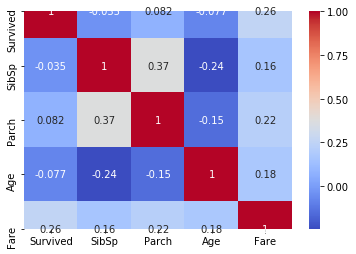

In [7]:
 g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

Correlations between numerical variables and Survived aren't so high but it doesn't mean that the other features are not useful.

In [8]:
def comparing(data,variable1, variable2):
    print(data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False))
    g = sns.FacetGrid(data, col=variable2).map(sns.distplot, variable1)

In [9]:
def counting_values(data, variable1, variable2):
    return data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False)

Parch vs Survived

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


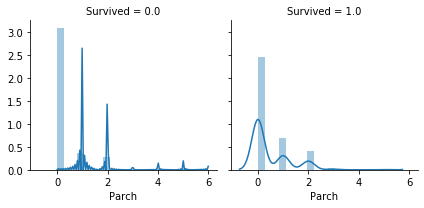

In [10]:
comparing(data, 'Parch','Survived')

SibSp vs Survived

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


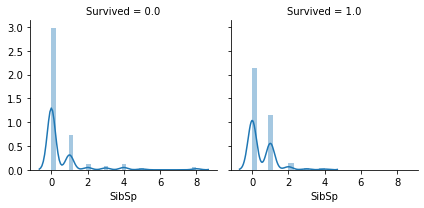

In [11]:
comparing(data, 'SibSp','Survived')

Fare vs Survived

         Fare  Survived
247  512.3292       1.0
196   57.9792       1.0
89    13.8583       1.0
88    13.7917       1.0
86    13.4167       1.0
..        ...       ...
103   15.5500       0.0
180   47.1000       0.0
179   46.9000       0.0
178   42.4000       0.0
124   21.0750       0.0

[248 rows x 2 columns]


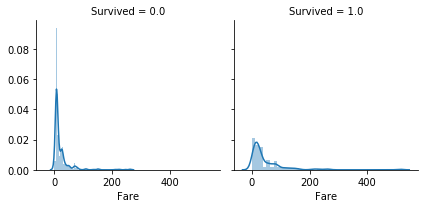

In [12]:
comparing(data, 'Fare','Survived')

Age vs Survived

      Age  Survived
0    0.42       1.0
9    5.00       1.0
79  63.00       1.0
68  53.00       1.0
1    0.67       1.0
..    ...       ...
37  28.50       0.0
49  36.50       0.0
46  34.50       0.0
26  20.50       0.0
30  23.50       0.0

[88 rows x 2 columns]


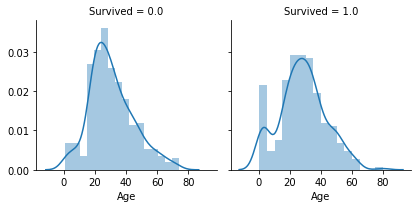

In [13]:
comparing(data, 'Age','Survived')

Sex vs Survived

In [14]:
counting_values(data, 'Sex','Survived')

,Sex,Survived
0,female,0.742038
1,male,0.188908


   Women  Survived
1      1  0.742038
0      0  0.188908


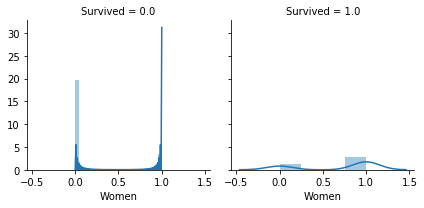

In [15]:
data['Women'] = np.where(data.Sex=='female',1,0)
comparing(data, 'Women','Survived')

Pclass vs Survived

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


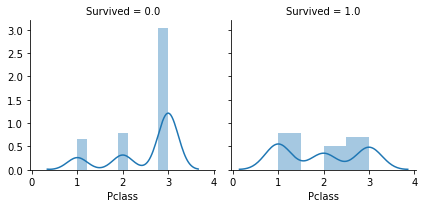

In [16]:
comparing(data, 'Pclass','Survived')

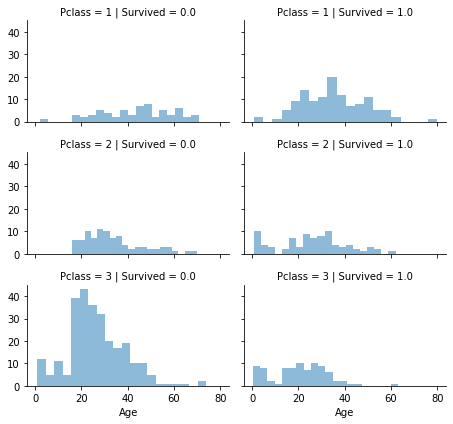

In [17]:
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)

Embarked vs Survived

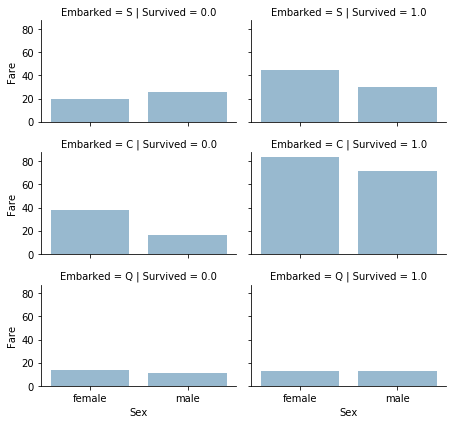

In [18]:
grid = sns.FacetGrid(data, row='Embarked', col='Survived', size=2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)

##**Missing values**

In [19]:
data.isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
Ticket         0
train          0
Women          0
dtype: int64

There are 263 missing ages, 1014 missing cabins. Age is very important variable, so it's worth spending time to imput them. If it comes to imputing cabins - it's too hard to do because dataset has only 1309 observations so 77% cabins are missing.

Missing values in Embarked and Fare variables are very easy to imput because we can use the most popular value or something like that.

I'm gonna replace missing value in Fare with 0 and in Embarked with the most popular value ('S').

In [20]:
data.groupby('Pclass').Fare.mean()

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [21]:
data.Fare = data.Fare.fillna(0)

In [22]:
print(data.Embarked.value_counts())
data.Embarked = data.Embarked.fillna('S')

S    914
C    270
Q    123
Name: Embarked, dtype: int64


If it comes to Cabin variable, I'm gonna fill up NaN values with 'Unknown' and get first letter from every Cabin in dataset.

In [23]:
data.Cabin = data.Cabin.fillna('Unknown')
data['Cabin'] = data['Cabin'].str[0]

Let's check the distribution of the cabins in individual passenger classes.

In [24]:
data.groupby('Pclass').Cabin.value_counts()

Pclass  Cabin
1       C         94
        U         67
        B         65
        D         40
        E         34
        A         22
        T          1
2       U        254
        F         13
        D          6
        E          4
3       U        693
        F          8
        G          5
        E          3
Name: Cabin, dtype: int64

The Cabin 'Unknown' will be set to C for the first class, D for the second class and G for the third class. One observation with Cabin 'T' and first class I'll fix with C.

In [25]:
data['Cabin'] = np.where((data.Pclass==1) & (data.Cabin=='U'),'C',
                                            np.where((data.Pclass==2) & (data.Cabin=='U'),'D',
                                                                        np.where((data.Pclass==3) & (data.Cabin=='U'),'G',
                                                                                                    np.where(data.Cabin=='T','C',data.Cabin))))

Now I'm gonna get title from each Name in dataset. This variable will be very useful and it can help to imput missing value in Age. People's titles can represent their age, earnings and life status and all these three properties can be associated with the possibility of survival on a ship.

In [26]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data['Title'], data['Sex'])
data = data.drop('Name',axis=1)

I need to replace a few titles with 'other' values because these titles are not as popular and have a low frequency of occurrence in this dataset.

In [27]:
#let's replace a few titles -> "other" and fix a few titles
data['Title'] = np.where((data.Title=='Capt') | (data.Title=='Countess') | (data.Title=='Don') | (data.Title=='Dona')
                        | (data.Title=='Jonkheer') | (data.Title=='Lady') | (data.Title=='Sir') | (data.Title=='Major') | (data.Title=='Rev') | (data.Title=='Col'),'Other',data.Title)

data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')

Let's check how the distribution of survival variable  depending on the title.

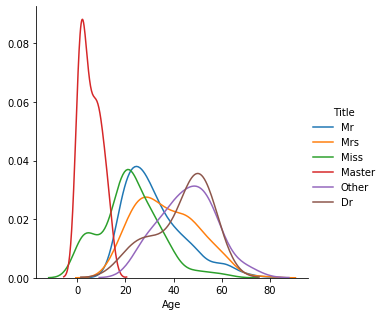

In [28]:
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = data, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

People with 'Master' have the highest survival rate. Maybe because people with the master are mainly boys under 13 years old.

Let's see distributions on box plots.

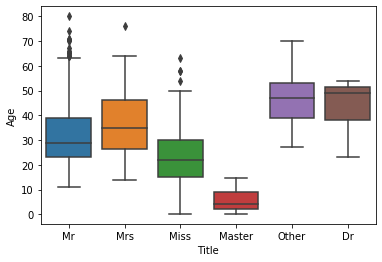

In [29]:
sns.boxplot(data = data, x = "Title", y = "Age")

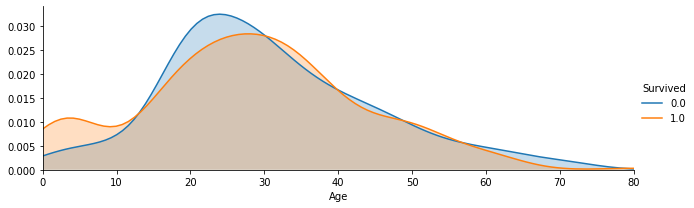

In [30]:
facet = sns.FacetGrid(data, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()

Age has a very large impact on the survival rate, but when this variable has missing values - it is useless. I'm gonna impute the missing values using the average age values in particular groups due to the titles.

In [31]:
data.groupby('Title').Age.mean()

Title
Dr        43.571429
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Other     45.714286
Name: Age, dtype: float64

In [32]:
data['Age'] = np.where((data.Age.isnull()) & (data.Title=='Master'),5,
                        np.where((data.Age.isnull()) & (data.Title=='Miss'),22,
                                 np.where((data.Age.isnull()) & (data.Title=='Mr'),32,
                                          np.where((data.Age.isnull()) & (data.Title=='Mrs'),37,
                                                  np.where((data.Age.isnull()) & (data.Title=='Other'),45,
                                                           np.where((data.Age.isnull()) & (data.Title=='Dr'),44,data.Age))))))                   

A few new variables:

##**Feature engineering**

* FamilySize - number of family members, people travelling alone will have a value of 1
* Women - it depends on Sex variable but I'm making it in binary way
* Mother - women with Mrs title and at least 1 parch, women, children and mothers probably have a survival factor
* Free - people who don't need to pay fare, these people could win tickets or something like that, they can have a similar survival rate
* TypeOfTicket - prefixes of ticket, tickets with same prefixes may have a similar class and survival.

If it comes to TypeOfTicket variable I'm gonna also replace a few values of this variable with 'other' values, relying on the same as in the case of titles.

In [33]:
data['FamilySize'] = data.SibSp + data.Parch + 1
data['Mother'] = np.where((data.Title=='Mrs') & (data.Parch >0),1,0)
data['Free'] = np.where(data['Fare']==0, 1,0)
data = data.drop(['SibSp','Parch','Sex'],axis=1)

In [34]:
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
    if len(splited_ticket) == 1:
                TypeOfTicket.append('NO')
    else: 
                TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket

data.TypeOfTicket.value_counts()
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'other',data.TypeOfTicket)
data = data.drop('Ticket',axis=1)

FamilySize vs Survived

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


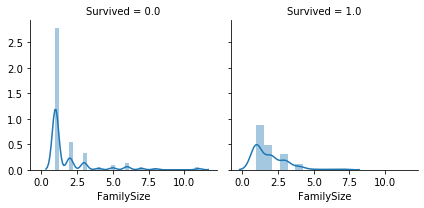

In [35]:
comparing(data, 'FamilySize','Survived')

Title vs Survived

In [36]:
counting_values(data, 'Title','Survived')

,Title,Survived
4,Mrs,0.793651
2,Miss,0.702703
1,Master,0.575000
0,Dr,0.428571
5,Other,0.312500
3,Mr,0.156673


TypeOfTicket vs Survived

In [37]:
counting_values(data, 'TypeOfTicket','Survived')

,TypeOfTicket,Survived
3,PC,0.650000
2,NO,0.383459
1,CA,0.341463
5,other,0.337079
4,SOTONOQ,0.133333
0,A5,0.095238


Cabin vs Survived

In [38]:
counting_values(data, 'Cabin','Survived')

,Cabin,Survived
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.540000
3,D,0.492537
0,A,0.466667
6,G,0.238095


Mother vs Survived

   Mother  Survived
1       1  0.714286
0       0  0.361677


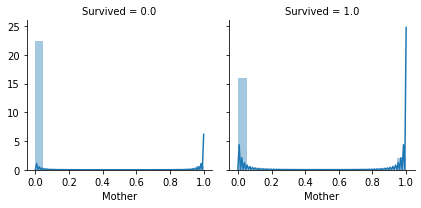

In [39]:
comparing(data, 'Mother','Survived')

Free vs Survived

   Free  Survived
0     0  0.389269
1     1  0.066667


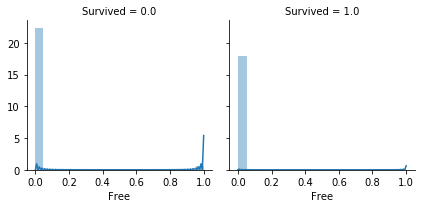

In [40]:
comparing(data, 'Free','Survived')

I'm cutting Age variable to 5 equal intervals.

In [41]:
bins = [0,12,24,45,60,data.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
data["Age"] = pd.cut(data["Age"], bins, labels = labels)

I create dummy variables for all variables with categories using the function get_dummies from pandas.

In [42]:
data = pd.get_dummies(data)

##**Modeling**
* Decision Tree Classifier
* Random Forest Classifier
* KNeighbors Classifier
* SVM
* Logistic Regression
* XGB Classifier

To check how good each model is I'm gonna split dataset to train (70%) and test (30%) dataset (excluding missing values in Survived variable) and use Accuracy Score from sklearn.metrics. I set random_state to 2019 in order to compare the results between the models.

In [43]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data[data.Survived.isnull()==False].drop('Survived',axis=1),data.Survived[data.Survived.isnull()==False],test_size=0.30, random_state=2019)

I'm gonna to put result of each model in Data Frame 'Results'

In [44]:
Results = pd.DataFrame({'Model': [],'Accuracy Score': [], 'Recall':[], 'F1score':[]})

In [45]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

**Decision Tree Classifier**

In [46]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [47]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,163,13
1.0,32,60


**Random Forest Classifier**

In [48]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [49]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,160,16
1.0,27,65


**KNeighbors Classifier**

In [50]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['KNeighborsClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [51]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,138,38
1.0,34,58


**SVM**

In [52]:
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [53]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,131,45
1.0,16,76


**Logistic Regression**

In [54]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [55]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,153,23
1.0,22,70


**XGB Classifier**

I put here some hyper-parameters tuning with n_estmators, max_depth and learning_rate parameters.

In [56]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)],
                   "Recall": [recall_score(testY, y_pred)],
                   "F1score": [f1_score(testY, y_pred)]})
Results = Results.append(res)

In [57]:
pd.crosstab(testY, y_pred, rownames=['Real data'], colnames=['Predicted'])

Predicted,0.0,1.0
Real data,,
0.0,159,17
1.0,23,69


##**Results**

In [58]:
Results

,Model,Accuracy Score,Recall,F1score
0,DecisionTreeClassifier,0.832090,0.652174,0.727273
0,RandomForestClassifier,0.839552,0.706522,0.751445
0,KNeighborsClassifier,0.731343,0.630435,0.617021
0,SVC,0.772388,0.826087,0.713615
0,LogisticRegression,0.832090,0.760870,0.756757
0,XGBClassifier,0.850746,0.750000,0.775281


How we see - XGB Classifier gives the best results. This model helps me to get 0.81339 on competition test dataset and it gives me place in 5% best results on Leaderboard.

In [59]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
test = data[data.train==0]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submissionXGB.csv",index=False)
print("done1")

done1
